La metologia presentada en este pynotebook se repite para las correlaciones de sierra y costa, y para cualquier correlacion entre las variables a escoger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xarray as xr

In [ ]:
import matplotlib.pyplot as plt

##shapefiles and crops


In [ ]:
%%capture
!pip install geopandas
!pip install rioxarray

In [ ]:
import rioxarray
from geopandas import read_file as gpd_read_file

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
!pip install importlib-metadata==4.13
!pip install geopandas
!pip install rasterio
!pip install scipy
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shp_regiones = gpd.read_file("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/shps/areas naturales del peru/region natural_geogpsperu_JuanPabloSuyoPomalia.shp")
shp_regiones_selva = shp_regiones.loc[shp_regiones.Nm_RegNat == 'Selva']
#para verificar cual es el shape que se ha seleccionado
shp_regiones_selva.geometry.values[0]
shp_regiones

,OBJECTID,GlobalID,Escala,Fuente,Cod_RegNat,Nm_RegNat,SHAPE_Leng,SHAPE_Area,contacto,web,whatsapp,geometry
0,1,{4DB64834-22F3-492A-8461-71DE7B0B6394},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,2,Sierra,87.894629,31.486141,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"MULTIPOLYGON (((-74.72973 -11.61102, -74.72932..."
1,2,{8F2361F2-9CE0-44F5-8210-D3A8DFAB7A41},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,3,Selva,92.589739,62.876535,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-69.11407 -14.48779, -69.11434 -14.4..."
2,3,{D2806CDD-429B-4606-A38B-EAB1DFBB7845},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,1,Costa,75.671063,12.250577,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"MULTIPOLYGON (((-79.80161 -4.48881, -79.80155 ..."


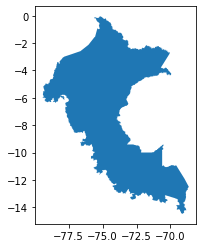

In [ ]:
shp_regselva=shp_regiones.iloc[[1]]
shp_regselva.plot()

In [ ]:
def xr_crop(shp_i, netcdf_i):
  
  # get box
  #crop hjace un corte en el cuadrante como un where
  box_i = shp_i.total_bounds# te da el cuadrante del del shapefile 
  
  # crop based on box
  #para utilizar el where
  #se esta definiendo los boxsiuads
  crop_netcdf_i = netcdf_i.where((netcdf_i["longitude"] > box_i[0]) & # min lon
                                 (netcdf_i["longitude"] < box_i[2]) & # max lon
                                 (netcdf_i["latitude"] > box_i[1]) & # min lat
                                 (netcdf_i["latitude"] < box_i[3]), # max lat
                                 drop = True) #es para que se saque todo el area que no nos interesa
  
  return crop_netcdf_i

def xr_shp_to_grid(shp_i, netcdf_array):

  #conversion de shpafile a un  dato grillado 
  
  # get real box
  shp_i_geometry = shp_i.geometry

  # adding crs #creating xarray dataset
  mask = netcdf_array.rio.set_crs(shp_i.crs)

  # "rasterizing"
  #se denomina como rasterización, se hace un clip para un shp determinado
  mask = mask.rio.clip(shp_i_geometry, drop = True)

  #coinciden los puntos de grilla con los datos del punto de grilla
  mask.values[~np.isnan(mask.values)] = 1 

  
  return mask.drop(["time"]) #se quita el time y el spatial_ref
#xrcrop :: como el where te hace un corte de un cuadrado
#xr_mask :: corte en base del poligono

#netcdf_i ->dato grillado
#shp_i -> shapefile
#grid mask -> mask
def xr_mask(grid_mask, netcdf_i):
  # masking
  #se hace un crop en base al mask gr
  mask_netcdf_i = netcdf_i.where(grid_mask == True)

  return mask_netcdf_i

In [ ]:
#definiendo un shapefile de departamentos
shp_peru = gpd.read_file("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/shps/Departamentos.shp")
shp_peru.head()

,DEPCOD,DEPNOM,geometry
0,01,AMAZONAS,"POLYGON ((-77.71584 -5.10859, -77.71561 -5.108..."
1,02,ANCASH,"POLYGON ((-77.43826 -8.41625, -77.43879 -8.419..."
2,03,APURIMAC,"POLYGON ((-73.51174 -13.38481, -73.50822 -13.3..."
3,04,AREQUIPA,"POLYGON ((-71.89395 -14.78905, -71.89342 -14.7..."
4,05,AYACUCHO,"POLYGON ((-73.74697 -13.75935, -73.74495 -13.7..."


##define variables

In [ ]:
#abriendo dataset
WG_5 = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/WGLC/wglc_climatology_05m.nc")
#cambiando los nombres de las dimensiones
WG_5=WG_5.rename({"lon":"longitude","lat":"latitude"})
WG_5.density.isel(time=0)

In [ ]:
#set crs --- set cordenadas geograficas
WG_5.rio.set_crs(shp_regiones_selva.crs)
WG_5CRP=xr_crop(shp_i=shp_regiones_selva,netcdf_i=WG_5)
#shape to grid
WG_5_grid=xr_shp_to_grid(shp_i = shp_regiones_selva, netcdf_array = WG_5.density.isel(time=0))
#make a mask
WG_5MASK=xr_mask(grid_mask=WG_5_grid, netcdf_i=WG_5CRP)


In [ ]:
WG_5MASK_WSR=WG_5MASK.drop_vars("spatial_ref")

In [ ]:
WG_5MASK_WSR["time"]=np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
WG_5MASK_WSR

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 173, longitude: 129)
Coordinates:
  * latitude   (latitude) float64 -14.46 -14.38 -14.29 ... -0.2083 -0.125
  * longitude  (longitude) float64 -79.38 -79.29 -79.21 ... -68.88 -68.79 -68.71
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [ ]:
CC = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/CC.nc")
CC=CC.rename({"z": "time"})
CC=CC.rio.set_crs(shp_peru.crs)

In [ ]:
# PISCOp_monthly.rio.set_crs(shp_climsel.crs)
CC_croped=xr_crop(shp_i=shp_regiones_selva,netcdf_i=CC)
#shape to grid
CC_grid=xr_shp_to_grid(shp_i = shp_regiones_selva, netcdf_array = CC.variable.isel(time=1))
#make a mask
CC_MASK=xr_mask(grid_mask=CC_grid, netcdf_i=CC_croped)

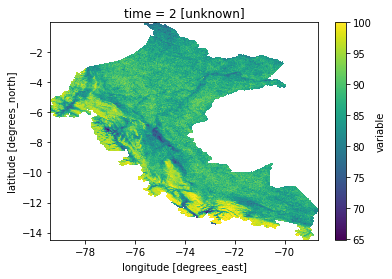

In [ ]:
#drop vars
CC_MASK_wcrs=CC_MASK.drop_vars("crs")
CC_MASK_wcrs.variable[1,:,:].plot()

In [ ]:
WG_5MASK_WSR.density[1,:,:]

<xarray.DataArray 'density' (latitude: 173, longitude: 129)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -14.46 -14.38 -14.29 ... -0.2083 -0.125
  * longitude  (longitude) float64 -79.38 -79.29 -79.21 ... -68.88 -68.79 -68.71
    time       object 0000-02-01 00:00:00
Attributes:
    long_name:  frequency of lightning strokes per unit area
    units:      strokes km-2 d-1

In [ ]:
#CC se interpola de mayor a menor resolución
CC_MASK_interpolated=CC_MASK_wcrs.variable.interp_like(WG_5MASK_WSR,method="nearest")
CC_MASK_interpolated=CC_MASK_interpolated.to_dataset()

In [ ]:
#pasando de 2D a una dimension para que se pueda hacer de manera correcta la interpolación
def cor_point_grid2(x, y):
  res = pd.DataFrame({"x":x.ravel(),"y":y.ravel()})
  res = res.corr().to_numpy()[0,1]
  return res

In [ ]:
cor_field_field_space = xr.apply_ufunc(cor_point_grid2,
                                       CC_MASK_interpolated.variable,
                                       WG_5MASK_WSR,
                                       input_core_dims=[["latitude","longitude"], ["latitude","longitude"]],
                                       vectorize=True)
cor_field_field_space

<xarray.Dataset>
Dimensions:  (time: 12)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density  (time) float64 -0.01296 -0.1228 -0.1397 ... -0.09231 0.01492 0.1392

In [ ]:
#save to csv
correlacion_Selva=cor_field_field_space.to_dataframe()
correlacion_Selva.to_csv("corr_Selva.csv")

In [ ]:
#se incorpora con otros csv
CORR_COSTA=pd.read_csv("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/correlacion/correlación_costa.csv")
CORR_COSTA

,time,density
0,1,0.089291
1,2,0.321698
2,3,0.460257
3,4,0.317394
4,5,0.252619
5,6,0.064673
6,7,-0.070918
7,8,0.050389
8,9,0.146327
9,10,0.267799


In [ ]:
#se incorpora con el dataset de sierra
CORR_SIERRA=pd.read_csv("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/correlacion/sierra correlación.csv")
CORR_SIERRA

,time,density
0,1,-0.112616
1,2,-0.282006
2,3,-0.245762
3,4,-0.226035
4,5,-0.017761
5,6,0.135958
6,7,-0.033163
7,8,-0.057250
8,9,-0.042637
9,10,0.187160


In [ ]:
corrs=cor_field_field_space.to_dataframe()
corrs["costa"]=list(CORR_COSTA["density"])
corrs["sierra"]=list(CORR_SIERRA["density"])
corrs.columns = ["SELVA", "COSTA", "SIERRA"]
corrs

,SELVA,COSTA,SIERRA
time,,,
1,-0.012960,0.089291,-0.112616
2,-0.122788,0.321698,-0.282006
3,-0.139737,0.460257,-0.245762
4,-0.030126,0.317394,-0.226035
5,0.024735,0.252619,-0.017761
6,0.042334,0.064673,0.135958
7,0.065506,-0.070918,-0.033163
8,0.052293,0.050389,-0.057250
9,-0.022135,0.146327,-0.042637


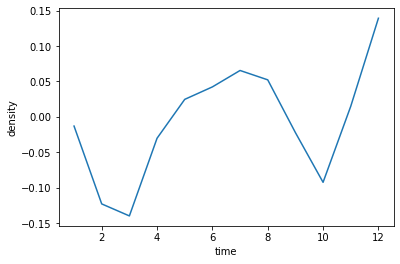

In [ ]:
cor_field_field_space.density.plot()